# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from arch import arch_model
import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()

В качестве ряда возьмем временной ряд индекса Доу Джонса

In [4]:
dowjones_closing = pd.read_csv("../data/Series/weekly-closings-of-the-dowjones-.csv")

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


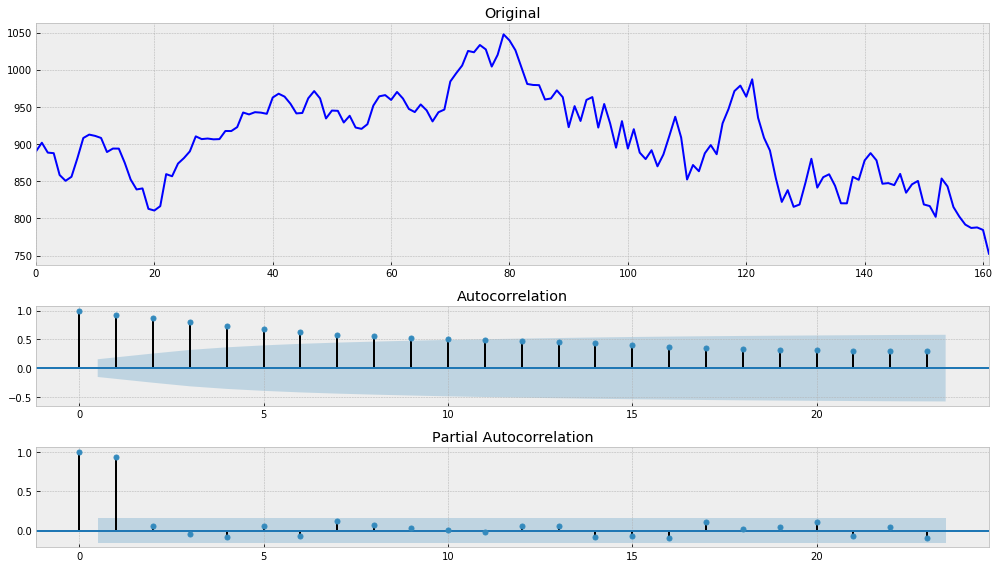

In [5]:
tsplot(dowjones_closing.Close)

Строим модель ARIMA, подбираем параметры по минимальному критерию Акаике

In [6]:
def get_best_model(TS, max_p, max_d, max_q):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for p, d, q in itertools.product(range(max_p), range(max_d), range(max_q)):
        try:
            tmp_mdl = smt.ARIMA(TS, order=(p,d,q)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p, d, q)
                best_mdl = tmp_mdl
        except: continue
    return best_aic, best_order, best_mdl

In [7]:
aic, order, mdl = get_best_model(dowjones_closing.Close, 5, 5, 5)

In [8]:
aic, order

(1416.2766997959206, (2, 2, 3))

Results of Dickey-Fuller Test:
Test Statistic                -1.184570e+01
p-value                        7.408658e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


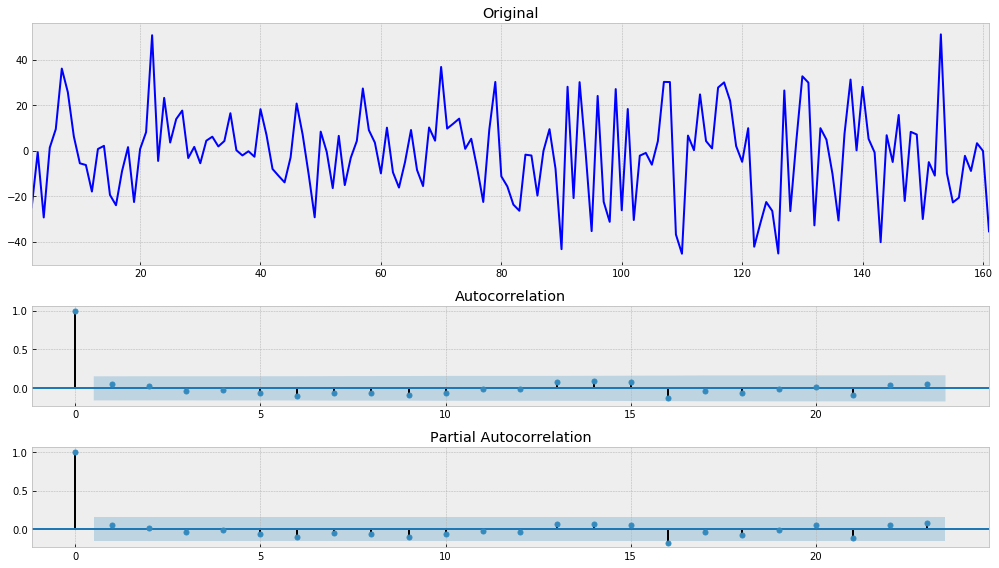

In [9]:
# посмотрим на остатки
tsplot(mdl.resid)

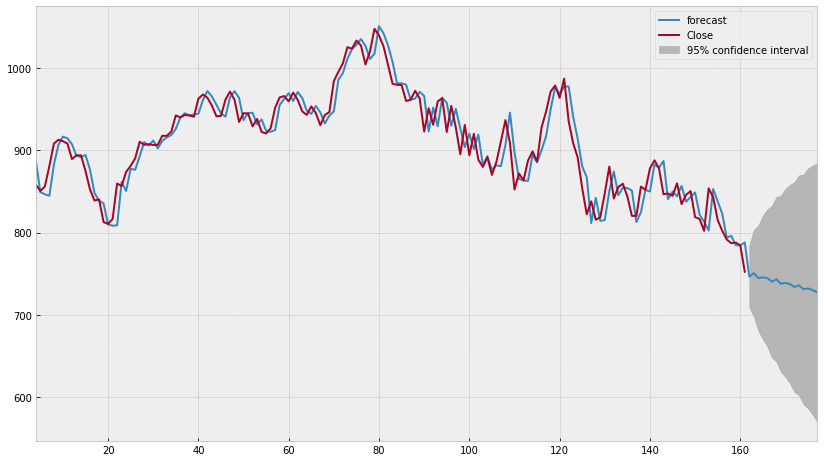

In [10]:
#посмотрим предсказания модели
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(end=len(dowjones_closing.Close)+15, ax=ax)
    plt.legend()
    plt.show()

Строим GARCH модель

In [11]:
am = arch_model(dowjones_closing.Close, p=order[0], o=order[1], q=order[2], dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Close   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -853.646
Distribution:      Standardized Student's t   AIC:                           1727.29
Method:                  Maximum Likelihood   BIC:                           1758.17
                                              No. Observations:                  162
Date:                      Wed, Mar 11 2020   Df Residuals:                      152
Time:                              00:22:22   Df Model:                           10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


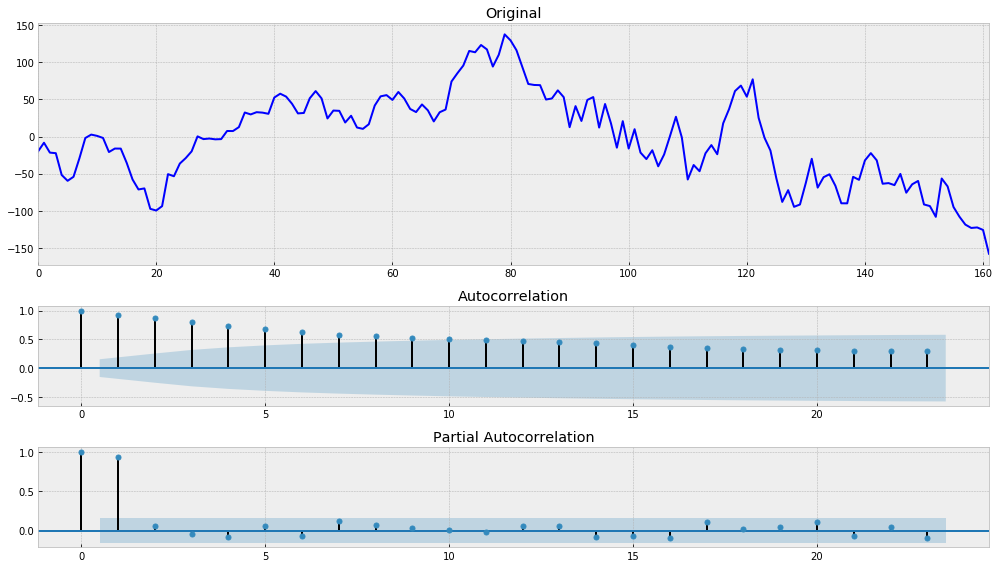

In [12]:
tsplot(res.resid)

Прогнозируем ряд с помощью линейной регрессии. Для работы алгоритма создаем фичи, которые получаются сдвигом ряда на опеределенный лаг, количество фич - гиперпараметр

In [13]:
dowjones_closing.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [14]:
def prepare_data(data, lag_start, lag_end, test_size):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = prepare_data(dowjones_closing, lag_start=1, lag_end=10, test_size=0.3)

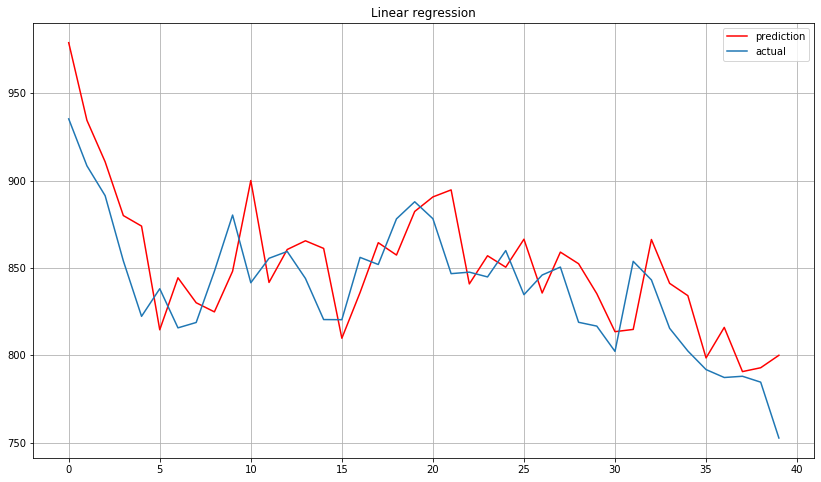

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);